In [52]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import ConversationalRetrievalChain
from langchain.llms import Ollama


In [53]:
pdf_path = "FR.pdf"

In [54]:
loader = PyPDFLoader(pdf_path)
pages = loader.load_and_split()
print(pages[0])

page_content='6
PART III FUNDAMENTAL RIGHTSGeneral12. Definition.—In this Part, unless the context otherwise requires, “the State” includes the Government and Parliament of India and the Government and the Legislature of each of the States and all local or other authorities within the territory of India or under the control of the Government of India.13. Laws inconsistent with or in derogation of the fundamental rights.—(1) All laws in force in the territory of India immediately before the commencement of this Constitution, in so far as they are inconsistent with the provisions of this Part, shall, to the extent of such inconsistency, be void.(2) The State shall not make any law which takes away or abridges the rights conferred by this Part and any law made in contravention of this clause shall, to the extent of the contravention, be void.(3) In this article, unless the context otherwise requires,—(a) “law” includes any Ordinance, order, bye-law, rule, regulation, notification, custom 

In [55]:
chunks = pages


In [56]:
import PyPDF2

In [57]:
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

In [58]:
text = extract_text_from_pdf(pdf_path)

In [59]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

In [60]:
def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

In [61]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=24,
    length_function=count_tokens,
)

In [62]:
chunks = text_splitter.create_documents([text])

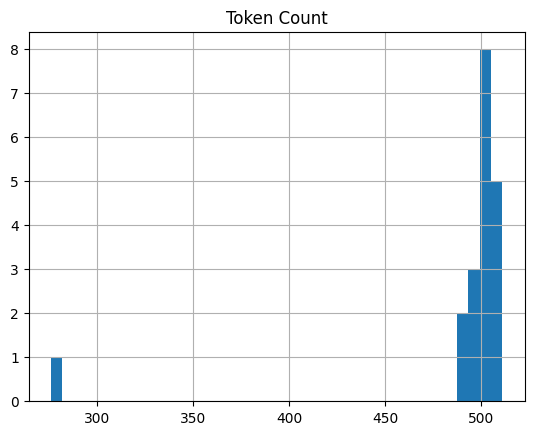

In [63]:
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]
df = pd.DataFrame({'Token Count': token_counts})
df.hist(bins=40)
plt.show()

In [64]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db = FAISS.from_documents(chunks, embeddings)

In [65]:
query = "What are Large Language Models?"
docs = db.similarity_search(query)
print(docs[0])

page_content='(a) Parliament shall have, and the Legislature of a State shall not 
have, power to make laws—
(i) with respect to any of the matters which under clause (3) of 
article 16, clause (3) of article 32, article 33 and article 34 may be 
provided for by law made by Parliament; and 
(ii) for prescribing punishment for those acts which are declared 
to be offences under this Part,
and Parliament shall, as soon as may be after the commencement of this 
Constitution, make laws for prescribing punishment for the acts referred 
to in sub-clause ( ii);
(b) any law in force immediately before the commencement of this 
Constitution in the territory of India with respect to any of the matters 
referred to in sub-clause ( i) of clause ( a) or providing for punishment for 
any act referred to in sub-clause ( ii) of that clause shall, subject to the 
terms thereof and to any adaptations and modifications that may be made 
therein under article 372, continue in force until altered or repeal

In [66]:
llm = Ollama(model="tinyllama")


In [67]:
qa = ConversationalRetrievalChain.from_llm(llm, db.as_retriever())

In [68]:
from IPython.display import display
import ipywidgets as widgets


In [69]:
print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

chat_history = []
while True:
    query = input("\nPlease enter your question: ")
    if query.lower() == 'exit':
        print("Thank you for using the chatbot!")
        break
    
    result = qa({"question": query, "chat_history": chat_history})
    print(f"\nChatbot: {result['answer']}")
    chat_history.append((query, result['answer']))

Welcome to the Transformers chatbot! Type 'exit' to stop.

Chatbot: This PDF contains a list of amendments to the Constitution of India, which include various provisions relating to land reform, tenants' rights, agrarian laws, and compensation for displaced people. The amendments also include the establishment of a National Land Commission and the creation of a Fund for Compensation for Land Acquired for public purposes. Additionally, various laws are strengthened or relaxed related to land acquisition, land reforms, and tenants' rights. These amendments were passed by the Constituent Assembly on December 19, 1950, but did not become effective until April 1, 1951.
Thank you for using the chatbot!


In [70]:
# import fitz  # PyMuPDF

# def extract_pages(input_pdf, output_pdf, start_page, end_page):
#     # Open the original PDF
#     doc = fitz.open(input_pdf)

#     # Create a new PDF
#     new_doc = fitz.open()

#     # Extract pages and add them to the new PDF
#     for page_num in range(start_page - 1, end_page):  # PyMuPDF uses 0-based index
#         new_doc.insert_pdf(doc, from_page=page_num, to_page=page_num)

#     # Save the extracted pages as a new PDF
#     new_doc.save(output_pdf)
#     new_doc.close()

# # Example usage
# input_pdf_path = "Constitution.pdf"
# output_pdf_path = "FR.pdf"
# extract_pages(input_pdf_path, output_pdf_path, 37, 51)
# print("PDF extraction complete! Saved as:", output_pdf_path)


In [71]:
from transformers import GPT2TokenizerFast
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import ConversationalRetrievalChain
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.llms import Ollama
import PyPDF2
import textwrap

# Configuration
PDF_PATH = "FR.pdf"
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
LLM_MODEL = "tinyllama"

def extract_text_from_pdf(pdf_path: str) -> str:
    """Extract text from PDF using PyPDF2 with error handling."""
    try:
        text = ""
        with open(pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for page in reader.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        return text
    except Exception as e:
        raise RuntimeError(f"Failed to process PDF: {str(e)}")

def create_chunks(text: str) -> list:
    """Create optimally sized text chunks."""
    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    
    def count_tokens(text: str) -> int:
        return len(tokenizer.encode(text))
    
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=512,
        chunk_overlap=64,  # Increased overlap for better context retention
        length_function=count_tokens,
        separators=["\n\n", "\n", ". ", " ", ""]  # Better splitting hierarchy
    )
    return text_splitter.split_text(text)

def initialize_qa_system():
    """Initialize the QA system with error handling."""
    try:
        # Process PDF
        text = extract_text_from_pdf(PDF_PATH)
        if not text:
            raise ValueError("No text extracted from PDF")
        
        # Create chunks
        chunks = create_chunks(text)
        if not chunks:
            raise ValueError("No chunks created from text")
        
        # Initialize embeddings and vector store
        embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
        db = FAISS.from_texts(chunks, embeddings)
        
        # Initialize LLM with streaming
        llm = Ollama(
            model=LLM_MODEL,
            temperature=0.3,  # Reduced for more focused answers
            callbacks=[StreamingStdOutCallbackHandler()]
        )
        
        return ConversationalRetrievalChain.from_llm(
            llm,
            db.as_retriever(search_kwargs={"k": 3}),  # Return top 3 relevant chunks
            return_source_documents=True
        )
    except Exception as e:
        print(f"Initialization error: {str(e)}")
        return None

def format_response(response: str) -> str:
    """Format long responses with text wrapping."""
    return "\n".join(textwrap.wrap(response, width=80))

def chat_interface():
    """Main chat interface."""
    print("Welcome to the Enhanced Chatbot! Type 'exit' to quit.\n")
    qa = initialize_qa_system()
    if not qa:
        return
    
    chat_history = []
    
    while True:
        try:
            query = input("\nYour question: ").strip()
            if query.lower() == 'exit':
                print("\nThank you for using the chatbot!")
                break
            if not query:
                continue
                
            result = qa({"question": query, "chat_history": chat_history})
            
            print("\n\nResponse:")
            formatted_answer = format_response(result["answer"])
            print(f"\n{formatted_answer}")
            
            # Store conversation context
            chat_history.append((query, result["answer"]))
            
        except KeyboardInterrupt:
            print("\nOperation cancelled by user.")
            break
        except Exception as e:
            print(f"\nError processing request: {str(e)}")

if __name__ == "__main__":
    chat_interface()

Welcome to the Enhanced Chatbot! Type 'exit' to quit.

Sure, here's a detailed explanation of the fundamental rights mentioned in the Constitution of India:

1. Article 14: The State shall not deny to any citizen on grounds only of religion, race, caste, sex or place of birth any right to property, liberty of conscience, freedom of thought, expression, belief, faith and worship, unless it is established that such denial is made for a valid reason.

2. Article 15: The State shall not discriminate against any citizen on grounds only of religion, race, caste, sex or place of birth in matters of education, employment, public service, and other public enterprises.

3. Article 16: Every citizen has the right to move the Supreme Court for a declaration that a law is unconstitutional or violative of any of the fundamental rights granted under this Constitution.

4. Article 17: The State shall not deny to any citizen the equal protection of the laws within the territory of India.

5. Article 18

In [73]:
import os
import PyPDF2
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import ConversationalRetrievalChain
from langchain.llms import Ollama
from langchain.prompts import PromptTemplate

class PDFChatBot:
    def __init__(self, pdf_path, model_name="tinyllama"):
        self.pdf_path = pdf_path
        self.model_name = model_name
        self.qa_chain = None
        self.vector_store = None
        self._initialize()

    def _extract_text(self):
        """Extract text from PDF with validation"""
        text = ""
        with open(self.pdf_path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            if len(reader.pages) == 0:
                raise ValueError("PDF contains no pages")
            for page in reader.pages:
                text += page.extract_text() + "\n"
        return text if text.strip() else None

    def _create_vector_store(self, text):
        """Create optimized vector store with medical context preservation"""
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1024,
            chunk_overlap=128,
            separators=["\n\n", "\n", "(?<=\. )", " ", ""]
        )
        
        chunks = text_splitter.split_text(text)
        embeddings = HuggingFaceEmbeddings(
            model_name="sentence-transformers/all-MiniLM-L6-v2",
            model_kwargs={'device': 'cpu'}
        )
        
        self.vector_store = FAISS.from_texts(
            chunks, 
            embeddings,
            metadatas=[{"source": self.pdf_path} for _ in chunks]
        )

    def _create_qa_chain(self):
        """Create strictly context-enforced QA chain"""
        custom_prompt = PromptTemplate(
            template=(
                "Use only the following context to answer. If unsure, say 'I don't know'.\n"
                "Context: {context}\n"
                "Question: {question}\n"
                "Answer:"
            ),
            input_variables=["context", "question"]
        )

        llm = Ollama(
            model=self.model_name,
            temperature=0.1,  # Strict factual responses
            system="You are a document analysis assistant. Base answers strictly on provided context.",
            stop=["<|endoftext|>"]
        )

        self.qa_chain = ConversationalRetrievalChain.from_llm(
            llm=llm,
            retriever=self.vector_store.as_retriever(search_kwargs={"k": 3}),
            combine_docs_chain_kwargs={"prompt": custom_prompt},
            return_source_documents=True
        )

    def _initialize(self):
        text = self._extract_text()
        if not text:
            raise ValueError("No text extracted from PDF")
        
        self._create_vector_store(text)
        self._create_qa_chain()

    def chat(self, query, history=None):
        """Process query with strict context enforcement"""
        if not history:
            history = []
            
        result = self.qa_chain({
            "question": query,
            "chat_history": history
        })
        
        # Verify answer against sources
        source_pages = {doc.metadata.get('page', '') for doc in result['source_documents']}
        verification = f"\n[Verified against pages: {', '.join(map(str, source_pages))}]" if source_pages else ""
        
        return {
            "answer": result['answer'] + verification,
            "history": history + [(query, result['answer'])]
        }

# Usage
if __name__ == "__main__":
    bot = PDFChatBot("FR.pdf", model_name="tinyllama")  # Use llama2 for better quality
    
    chat_history = []
    print("PDF Expert Bot: Ask me anything about the document (type 'exit' to quit)")
    
    while True:
        try:
            query = input("\nYou: ")
            if query.lower() in ('exit', 'quit'):
                break
                
            response = bot.chat(query, chat_history)
            print(f"\nBot: {response['answer']}")
            chat_history = response["history"]
            
        except KeyboardInterrupt:
            print("\nSession ended.")
            break

PDF Expert Bot: Ask me anything about the document (type 'exit' to quit)

Bot: Use only the following context to answer. If unsure, say 'I don't know'.
Context: referred to in sub-clause ( i) of clause ( a) or providing for punishment for any act referred to in sub-clause ( ii) of that clause shall, subject to the term(s) thereof and to any adaptation(s) and modifications(s) under article 372, continue in force until altered or repealed or amended by Parliament. Explain: This article refers to a specific law, namely "Compulsory acquisition of property" which is mentioned in the context of "Laws providing for acquisiion of estate, etc." and "Amalgamation of two or more corporations". The law in question is not mentioned explicitly but it is implied as part of the context.
[Verified against pages: ]


Notes to remember:

Whenever a user visits the site, he/she will explain his/her problems. I will have to create the chatbot in such a way that the user gets the feel of an interactive website. He should feel that he/she is interactive with the whole of website. Infact I can automate the website completely. Which when asked by the user can work like an open book. When the user asks something of it, it can check its functionality and show the user its features and the features will be automatically open themselves and take the user to that part of the website 